**TODO:**
* **Critical:** dive into inflation expectations in the first half of 20th century
    * golden standard?
    * Production function as a proxy of the inflation expectations?
- Test on data of different countries

In [1]:
import pandas as pd
import numpy as np
from typing import Sequence

np.set_printoptions(suppress=True)

%matplotlib widget

In [2]:
import os
if not os.path.exists("dataset.csv"):
    %run data_preparation.py

dataset = pd.read_csv("dataset.csv",index_col="year",date_format="%Y-%m-%d")

**Developing a model to describe the phenomenon**

In [3]:
y = dataset["inflation_rate"]
X = dataset.drop(columns="inflation_rate")

Linear regeression

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
results = model.fit(X,y)
coefs = results.coef_.squeeze()
intercept = results.intercept_

print(f"Coefficients:")
print(pd.Series(coefs,index=X.columns))
print(f"\nR-square: {round(model.score(X,y),4)}")

Coefficients:
mean_unemployment    -0.079112
expected_inflation    0.742150
dtype: float64

R-square: 0.405


Non linear curve (a*y)/(b*x) + c

In [5]:
def r_squared(model, X, y_act, **model_params) -> float:
    y_exp = model(X,**model_params)
    return 0

In [6]:
from scipy.optimize import curve_fit

def curve_func(X, a, b):
    """
    :param X: must be an iterable collection, where the first element is the mean unemployment and the second one is the expected inflation
    """
    x, y = X
    return a*(y/x) + b

popt, pcov = curve_fit(curve_func, X.to_numpy().T, y, p0=[1,0])

print("Coefficients: " + str(popt))
#print("R^2 = " + str(r_squared(curve_func, X, y, *popt)))

Coefficients: [0.02955407 0.01256489]


interactive(children=(IntSlider(value=12, description='elev', max=90, step=2), IntSlider(value=130, descriptio…

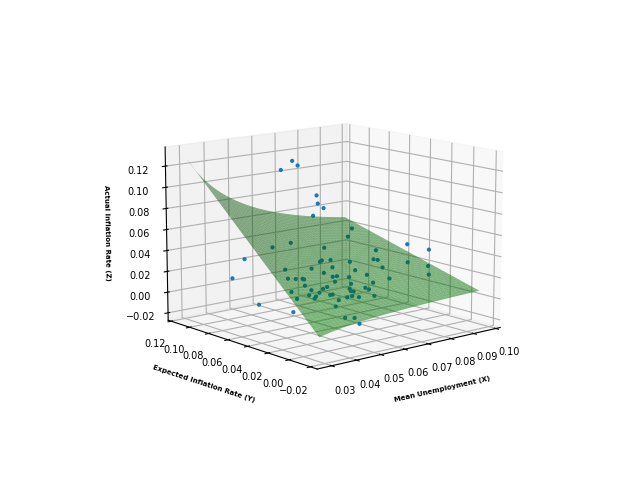

In [7]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed

# plotting the data points and the fitted curve
fig = plt.figure(clear=True)
ax = fig.add_subplot(projection='3d')
fontdict = {
    "fontweight":"bold",
    "size":5,
    "fontvariant":"normal"
}

ax.scatter(xs=dataset["mean_unemployment"], ys=dataset["expected_inflation"], zs=dataset["inflation_rate"], s=4, alpha=1)

# Figure
fig.set_label("Fitted unemployment, expected inflation and the actual inflation")

# X-axis
ax.set_xlabel("Mean Unemployment (X)",fontdict=fontdict)
ax.tick_params(axis="x",labelsize=7)

# Y-axis
ax.set_ylabel("Expected Inflation Rate (Y)",fontdict=fontdict);
ax.tick_params(axis="y",labelsize=7)

# Z-axis
ax.set_zlabel("Actual Inflation Rate (Z)",fontdict=fontdict)
ax.tick_params(axis="z",labelsize=7)

# plotting the function
x_range = np.linspace(dataset["mean_unemployment"].min(), dataset["mean_unemployment"].max(), num=100)
y_range = np.linspace(dataset["expected_inflation"].min(), dataset["expected_inflation"].max(), num=100) 
xx, yy = np.meshgrid(x_range, y_range)
zz = curve_func((xx, yy), *popt)
ax.plot_surface(xx, yy, zz, color='green', alpha=0.5)

# handling the interactive controls
ax.mouse_init()
ax.disable_mouse_rotation()

@interact(
    elev=(0, 90, 2), 
    azim=(0, 360, 2), 
    roll=fixed(0)
)
def update_plot(elev=12, azim=130, roll=0):
    ax.view_init(elev=elev, azim=-azim, roll=roll)
    fig.canvas.draw()